# ip data and binary data

Creating data frame with ip data in first few columns, followed by binary dns data for the remaining

In [1]:
from sklearn.utils import shuffle
import pandas as pd

def toint(row):
    row['1st Octet']=int(row['1st Octet'])
    row['2nd Octet']=int(row['2nd Octet'])
    row['3rd Octet']=int(row['3rd Octet'])
    row['4th Octet']=int(row['4th Octet'])
    return row

def ipcleanup(row):
    iprow=[]
    for address in row['A']:
        try:
            tempstring=address.split('IN A')
            iprow.append(tempstring[1].strip())
        except IndexError:  
            pass
    return iprow

def binarizer(cell):
    if cell[0]=="No Answer" or cell[0]=="Timeout":
        return 0
    else:
        return 1

goodcomplete=pd.read_parquet('../parsed data/gooddnsdata')
goodcomplete=goodcomplete.sample(66000)
badcomplete=pd.read_parquet('../parsed data/baddnsdata')

goodcomplete["indicator"]=goodcomplete["indicator"].apply(lambda x:x[0])
goodcomplete.insert(0,'Malicious',0)
badcomplete.insert(0,'Malicious',1)

badcomplete["indicator"]=badcomplete["indicator"].apply(lambda x: x[0])
badcomplete=badcomplete.drop_duplicates(subset="indicator")
##############################################################################
goodcomplete['A']=goodcomplete.apply(ipcleanup,axis="columns")
badcomplete['A']=badcomplete.apply(ipcleanup,axis="columns")

complete = goodcomplete.append(badcomplete,ignore_index=True)
#cut out rows with empty ip
complete=complete[complete['A'].map(lambda x: len(x)>0)]
complete.reset_index(inplace=True)

complete['A']=complete['A'].apply(lambda x:x[0])
expand=complete['A'].str.split(".",-1,expand=True)
complete["1st Octet"]=expand[0]
complete["2nd Octet"]=expand[1]
complete["3rd Octet"]=expand[2]
complete["4th Octet"]=expand[3]

#reorder
complete=complete[['indicator','Malicious', '1st Octet',"2nd Octet","3rd Octet","4th Octet",'A', 'AAAA', 'CAA', 'CNAME', 'DNAME', 'LOC', 'MX','RP', 'SIG', 'SSHFP' ]]
complete[['A', 'AAAA', 'CAA', 'CNAME', 'DNAME', 'LOC', 'MX','RP', 'SIG', 'SSHFP' ]]=complete[['A', 'AAAA', 'CAA', 'CNAME', 'DNAME', 'LOC', 'MX','RP', 'SIG', 'SSHFP' ]].applymap(binarizer)

In [2]:
from sklearn.preprocessing import OneHotEncoder
complete[['1st Octet',"2nd Octet","3rd Octet","4th Octet"]]=complete[['1st Octet',"2nd Octet","3rd Octet","4th Octet"]].astype(int)


good=complete[:62763]
bad=complete[62763:]

earlybad=bad.head(40000)
latebad=bad.tail(19000)

train=good.head(40000).append(earlybad).sample(frac=1)
test=good.tail(19000).append(latebad).sample(frac=1)

cats=[list(range(0,256)),list(range(0,256)),list(range(0,256)),list(range(0,256)),[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1]]

encoder=OneHotEncoder(categories=cats)
encodedtrain=encoder.fit_transform(train[["1st Octet","2nd Octet","3rd Octet","4th Octet",'AAAA', 'CAA', 'CNAME', 'DNAME', 'LOC', 'MX', 'RP', 'SIG',
      'SSHFP']])
encodedtest=encoder.fit_transform(test[["1st Octet","2nd Octet","3rd Octet","4th Octet",'AAAA', 'CAA', 'CNAME', 'DNAME', 'LOC', 'MX', 'RP', 'SIG',
      'SSHFP']])


# Logistic Regression

In [3]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
glm=LogisticRegression()

model=glm.fit(encodedtrain,train['Malicious'])
ypred=model.predict(encodedtest)
print(classification_report(test['Malicious'],ypred))


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.67      0.81      0.73     19000
           1       0.75      0.60      0.67     19000

   micro avg       0.70      0.70      0.70     38000
   macro avg       0.71      0.70      0.70     38000
weighted avg       0.71      0.70      0.70     38000



# MLP 

In [4]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

clf=MLPClassifier()

model=clf.fit(encodedtrain,train['Malicious'])
ypred=model.predict(encodedtest)
yprob=model.predict_proba(encodedtest)
print(classification_report(test['Malicious'],ypred))


              precision    recall  f1-score   support

           0       0.69      0.83      0.76     19000
           1       0.79      0.63      0.70     19000

   micro avg       0.73      0.73      0.73     38000
   macro avg       0.74      0.73      0.73     38000
weighted avg       0.74      0.73      0.73     38000



# Plotting IP data

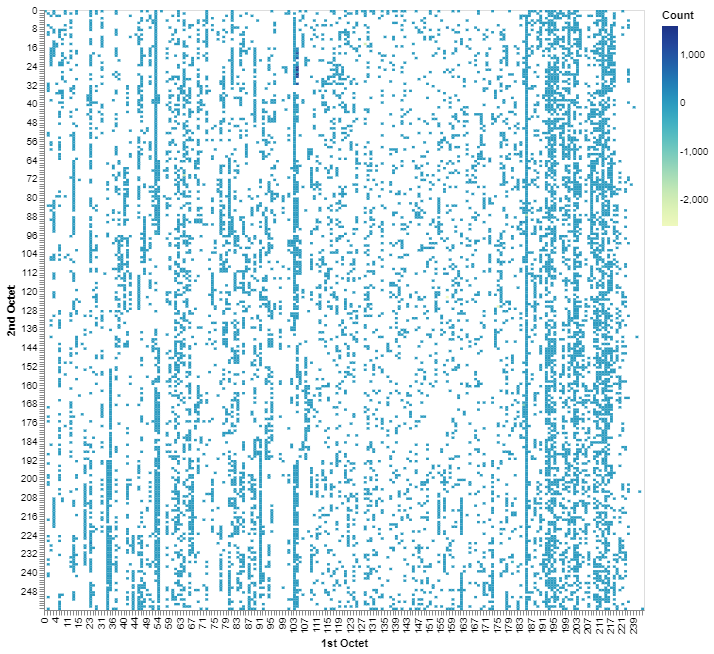

In [243]:
import altair as alt
import numpy as np
import pandas as pd

#remove nans so I can subtract things
def cleanup(cell):
    if cell!=cell:
        cell=0
    return cell
xgood=good[["1st Octet","2nd Octet"]].sample(59000)
xbad=bad[["1st Octet","2nd Octet"]].sample(59000)

alt.data_transformers.disable_max_rows()
alt.renderers.enable('notebook')
stuffg=xgood.groupby(['1st Octet','2nd Octet']).size().reset_index().rename(columns={0:'Count'})
stuffb=xbad.groupby(['1st Octet','2nd Octet']).size().reset_index().rename(columns={0:'Count'})

union=pd.concat([stuffg[["1st Octet","2nd Octet"]],stuffb[["1st Octet", "2nd Octet"]]]).drop_duplicates()

goodcomplete=union.merge(stuffg,how="left",on=["1st Octet", "2nd Octet"])
badcomplete=union.merge(stuffb,how="left",on=["1st Octet", "2nd Octet"])


goodcomplete=goodcomplete.applymap(cleanup)
badcomplete=badcomplete.applymap(cleanup)
#line below shows the difference
goodcomplete["Count"]=goodcomplete["Count"]-badcomplete["Count"]

alt.Chart(goodcomplete).mark_rect().encode(
    x="1st Octet:O",
    y="2nd Octet:O",
    color="Count").properties(width=600,height=600)

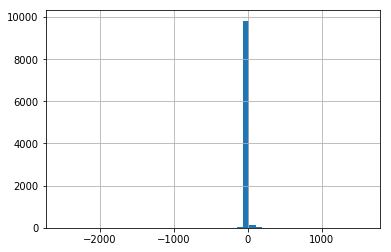

In [244]:
goodcomplete["Count"].hist(bins=50)

# RANDOM FOREST

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
rfc=RandomForestClassifier()
model=rfc.fit(encodedtrain,train['Malicious'])
ypred=model.predict(encodedtest)
print(classification_report(test['Malicious'],ypred))


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.70      0.88      0.78     19000
           1       0.84      0.62      0.71     19000

   micro avg       0.75      0.75      0.75     38000
   macro avg       0.77      0.75      0.75     38000
weighted avg       0.77      0.75      0.75     38000



# QDA

In [ ]:
from sklearn.svm import SVC
supportvec=SVC()
model=supportvec.fit(encodedtrain,train['Benign'])
ypred=model.predict(encodedtest)
print(classification_report(test['Benign'],ypred))


# NEAREST NEIGHBOR

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier()
model=knn.fit(encodedtrain,train['Benign'])
ypred=model.predict(encodedtest)
print(classification_report(test['Benign'],ypred))
